## Convert original bbox into the training format

height and width is: (1564, 2880)


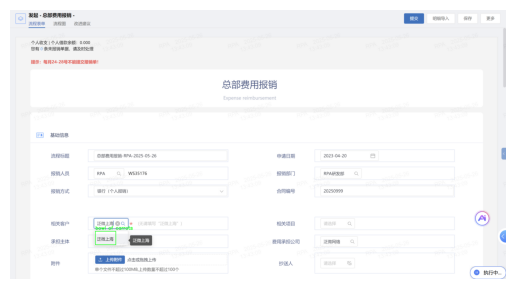

In [17]:
import cv2
import matplotlib.pyplot as plt

bboxes = [
    {"bbox_2d": [495, 1287, 614, 1365], "label": "bowl of carrots"},
]
image_path = "../dataset/images/25795df22868431b861389c0f4ab0ad3.png"
image = cv2.imread(image_path)

if image is None:
    print(f"cannot read image: {image_path}")
else:
    h, w = image.shape[:2]
    print(f'height and width is: {h, w}')
    for bbox_info in bboxes:
        bbox = bbox_info["bbox_2d"]
        label = bbox_info["label"]
        x1, y1, x2, y2 = bbox
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image)
    plt.axis('off')
    plt.show()
    

### Convert to Qwen2-VL training format

Qwen2-VL using the relative coordinated with range $0-1000$. For the original absolute coordinate, the should be be multiplied by 1000 and divided by its origin height and width.

In [2]:
def convert_to_qwen2vl_format(bbox, h, w):
    x1, y1, x2, y2 = bbox
    x1_new = round(x1 / w * 1000)
    y1_new = round(y1 / h * 1000)
    x2_new = round(x2 / w * 1000)
    y2_new = round(y2 / h * 1000)
    
    x1_new = max(0, min(x1_new, 1000))
    y1_new = max(0, min(y1_new, 1000))
    x2_new = max(0, min(x2_new, 1000))
    y2_new = max(0, min(y2_new, 1000))
    
    return [x1_new, y1_new, x2_new, y2_new]

print(convert_to_qwen2vl_format([146, 137, 615, 415], 428, 640))

[228, 320, 961, 970]


### Convert to Qwen2.5-VL training format

Qwen2.5-VL using the absolute coordinated for the resized image. For the original absolute coordinate, the should be be multiplied by resized height and width and divided by its origin height and width.

In [3]:
import math

# This is the resize function of Qwen2.5-VL
def smart_resize(
    height: int, width: int, factor: int = 28, min_pixels: int = 56 * 56, max_pixels: int = 14 * 14 * 4 * 1280
):
    """Rescales the image so that the following conditions are met:
    1. Both dimensions (height and width) are divisible by 'factor'.
    2. The total number of pixels is within the range ['min_pixels', 'max_pixels'].
    3. The aspect ratio of the image is maintained as closely as possible.
    """
    if height < factor or width < factor:
        raise ValueError(f"height:{height} or width:{width} must be larger than factor:{factor}")
    elif max(height, width) / min(height, width) > 200:
        raise ValueError(
            f"absolute aspect ratio must be smaller than 200, got {max(height, width) / min(height, width)}"
        )
    h_bar = round(height / factor) * factor
    w_bar = round(width / factor) * factor
    if h_bar * w_bar > max_pixels:
        beta = math.sqrt((height * width) / max_pixels)
        h_bar = math.floor(height / beta / factor) * factor
        w_bar = math.floor(width / beta / factor) * factor
    elif h_bar * w_bar < min_pixels:
        beta = math.sqrt(min_pixels / (height * width))
        h_bar = math.ceil(height * beta / factor) * factor
        w_bar = math.ceil(width * beta / factor) * factor
    return h_bar, w_bar


def convert_to_qwen25vl_format(bbox, orig_height, orig_width, factor=28, min_pixels=56*56, max_pixels=14*14*4*1280):
    new_height, new_width = smart_resize(orig_height, orig_width, factor, min_pixels, max_pixels)
    scale_w = new_width / orig_width
    scale_h = new_height / orig_height
    
    x1, y1, x2, y2 = bbox
    x1_new = round(x1 * scale_w)
    y1_new = round(y1 * scale_h)
    x2_new = round(x2 * scale_w)
    y2_new = round(y2 * scale_h)
    
    x1_new = max(0, min(x1_new, new_width - 1))
    y1_new = max(0, min(y1_new, new_height - 1))
    x2_new = max(0, min(x2_new, new_width - 1))
    y2_new = max(0, min(y2_new, new_height - 1))
    
    return [x1_new, y1_new, x2_new, y2_new]

print(convert_to_qwen25vl_format([146, 137, 615, 415], 428, 640))

[147, 134, 619, 407]
